# Import necessary libraries

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from datetime import datetime

# Load dataset

In [125]:
df = pd.ExcelFile(r'\Users\malak\Downloads\E-commerce_data.xlsx')
df.sheet_names

['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants']

# Load data sheets

In [126]:
# Load data sheets
customers_df = pd.read_excel(df, sheet_name='customers')
genders_df = pd.read_excel(df, sheet_name='genders')
cities_df = pd.read_excel(df, sheet_name='cities')
transactions_df = pd.read_excel(df, sheet_name='transactions')

#  Data Merging 
### Combining Customer & Transaction Data

In [127]:
# Merge gender and city names into the customers dataset
# Merge gender and city names into the customers dataset
customers_df = customers_df.merge(genders_df, on="gender_id", how="left")
customers_df = customers_df.merge(cities_df, on="city_id", how="left")
customers_df.drop(columns=["gender_id", "city_id"], inplace=True)
customers_df.head()

,customer_id,join_date,gender_name,city_name
0,1,2022-01-08,Male,Mansoura
1,2,2023-05-02,Female,Sohag
2,3,2023-05-14,Male,Aswan
3,4,2022-11-25,Female,Ismailia
4,5,2023-04-26,Male,El-Mahalla El-Kubra


In [128]:
# Merge customers with transactions
merged_df = customers_df.merge(transactions_df, on="customer_id", how="left")

# Exploratory Data Analysis (EDA) & Data cleaning

In [129]:
# Dataset shape
merged_df.shape

(5011, 10)

In [130]:
merged_df

,customer_id,join_date,gender_name,city_name,transaction_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id
0,1,2022-01-08,Male,Mansoura,178.0,2022-07-30,subscribed,SrP-866,NaT,8.0
1,1,2022-01-08,Male,Mansoura,257.0,2022-09-19,burned,krI-075,2022-11-05,1.0
2,1,2022-01-08,Male,Mansoura,1652.0,2022-06-09,burned,quk-137,2022-07-19,6.0
3,1,2022-01-08,Male,Mansoura,1929.0,2022-07-30,burned,QiG-754,2022-10-18,8.0
4,1,2022-01-08,Male,Mansoura,2352.0,2023-03-24,subscribed,OtC-985,NaT,4.0
...,...,...,...,...,...,...,...,...,...,...
5006,999,2022-07-16,Male,Suez,541.0,2023-05-18,burned,rqU-020,2023-07-15,8.0
5007,999,2022-07-16,Male,Suez,2216.0,2022-12-21,burned,VoR-120,2023-02-17,2.0
5008,999,2022-07-16,Male,Suez,3996.0,2024-04-09,burned,vGo-341,2024-05-07,3.0
5009,1000,2024-04-08,Female,Alexandria,1159.0,2024-04-20,subscribed,TmE-861,NaT,8.0


In [131]:
# checking nulls in the dataset
merged_df.isna().sum()

customer_id              0
join_date                0
gender_name              0
city_name                0
transaction_id          11
transaction_date        11
transaction_status      11
coupon_name             11
burn_date             2495
branch_id               11
dtype: int64

In [132]:
# Drop unnecessary column 'burn_date' (not needed for clustering)
merged_df.drop(columns=["burn_date"], inplace=True)

In [134]:
# since the missing values are too small so I dropped the missing values
merged_df=merged_df.dropna()

In [135]:
merged_df

,customer_id,join_date,gender_name,city_name,transaction_id,transaction_date,transaction_status,coupon_name,branch_id
0,1,2022-01-08,Male,Mansoura,178.0,2022-07-30,subscribed,SrP-866,8.0
1,1,2022-01-08,Male,Mansoura,257.0,2022-09-19,burned,krI-075,1.0
2,1,2022-01-08,Male,Mansoura,1652.0,2022-06-09,burned,quk-137,6.0
3,1,2022-01-08,Male,Mansoura,1929.0,2022-07-30,burned,QiG-754,8.0
4,1,2022-01-08,Male,Mansoura,2352.0,2023-03-24,subscribed,OtC-985,4.0
...,...,...,...,...,...,...,...,...,...
5006,999,2022-07-16,Male,Suez,541.0,2023-05-18,burned,rqU-020,8.0
5007,999,2022-07-16,Male,Suez,2216.0,2022-12-21,burned,VoR-120,2.0
5008,999,2022-07-16,Male,Suez,3996.0,2024-04-09,burned,vGo-341,3.0
5009,1000,2024-04-08,Female,Alexandria,1159.0,2024-04-20,subscribed,TmE-861,8.0


In [137]:
# checking duplicates
merged_df.duplicated().sum()

0

In [138]:
# Dataset info
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 5010
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         5000 non-null   int64         
 1   join_date           5000 non-null   datetime64[ns]
 2   gender_name         5000 non-null   object        
 3   city_name           5000 non-null   object        
 4   transaction_id      5000 non-null   float64       
 5   transaction_date    5000 non-null   datetime64[ns]
 6   transaction_status  5000 non-null   object        
 7   coupon_name         5000 non-null   object        
 8   branch_id           5000 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 390.6+ KB


In [139]:
# Dataset statistics 
merged_df.describe()

,customer_id,join_date,transaction_id,transaction_date,branch_id
count,5000.000000,5000,5000.000000,5000,5000.000000
mean,509.551600,2023-01-18 14:41:34.080000,2500.500000,2023-10-22 04:38:47.040000,5.529800
min,1.000000,2021-07-18 00:00:00,1.000000,2021-08-05 00:00:00,1.000000
25%,262.000000,2022-04-10 00:00:00,1250.750000,2023-05-31 18:00:00,3.000000
50%,514.000000,2023-01-11 00:00:00,2500.500000,2024-01-02 00:00:00,6.000000
75%,758.000000,2023-10-25 00:00:00,3750.250000,2024-05-08 00:00:00,8.000000
max,1000.000000,2024-07-13 00:00:00,5000.000000,2024-07-14 00:00:00,10.000000
std,287.065172,NaN,1443.520003,NaN,2.895788


In [ ]:
#Convert date columns to datetime format
merged_df["join_date"] = pd.to_datetime(merged_df["join_date"])
merged_df["transaction_date"] = pd.to_datetime(merged_df["transaction_date"])

# Feature Engineering - (Creating New Features for Clustering)

In [140]:
# Compute coupon usage frequency
coupon_usage = merged_df.groupby("customer_id")["coupon_name"].count().reset_index()
coupon_usage.rename(columns={"coupon_name": "coupon_usage_frequency"}, inplace=True)

# Count transactions by status per customer
transaction_status_counts = merged_df.pivot_table(index="customer_id",
                                                  columns="transaction_status",
                                                  values="transaction_id",
                                                  aggfunc="count",
                                                  fill_value=0).reset_index()

In [141]:
# Merge aggregated features into final dataset
final_df = customers_df.merge(coupon_usage, on="customer_id", how="left")
final_df = final_df.merge(transaction_status_counts, on="customer_id", how="left")
final_df.fillna(0, inplace=True)

In [151]:
final_df.isna().sum()

customer_id               0
join_date                 0
gender_name               0
city_name                 0
coupon_usage_frequency    0
burned                    0
subscribed                0
cluster                   0
dtype: int64

# Feature Selection (Choosing important features for Clustering)

In [142]:
# Select numerical features for clustering
features = ["coupon_usage_frequency", "burned", "subscribed"]


# Feature Scaling 

In [ ]:
# scale features using standardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_df[features])

# Model Training & Evaluation 
### to Find Optimal Clusters

In [143]:
# Compute Silhouette Scores and Davies-Bouldin Index for different cluster numbers
silhouette_scores = {}
davies_bouldin_scores = {}
cluster_options = range(2, 11)

for k in cluster_options:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    silhouette_scores[k] = silhouette_score(scaled_features, labels)
    davies_bouldin_scores[k] = davies_bouldin_score(scaled_features, labels)


C:\Users\malak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\malak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\malak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\malak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

In [144]:
# Choose the optimal number of clusters based on the highest Silhouette Score
optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")

Optimal number of clusters based on Silhouette Score: 9


# Apply K-Means with Optimal Clusters

In [145]:
# Apply K-Means with the optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_df["cluster"] = kmeans.fit_predict(scaled_features)

C:\Users\malak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


# Visualizing Clustering Results

### Plot Silhouette Scores

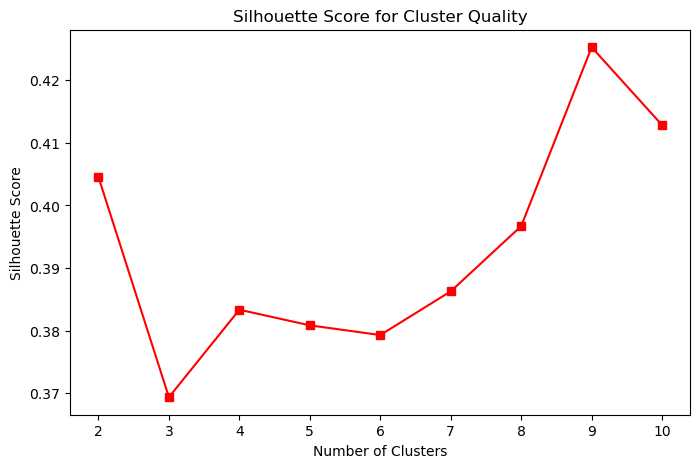

In [146]:
plt.figure(figsize=(8, 5))
plt.plot(cluster_options, silhouette_scores.values(), marker="s", linestyle="-", color="red")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Cluster Quality")
plt.show()

### Plot Elbow Method for reference

C:\Users\malak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\malak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\malak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\malak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

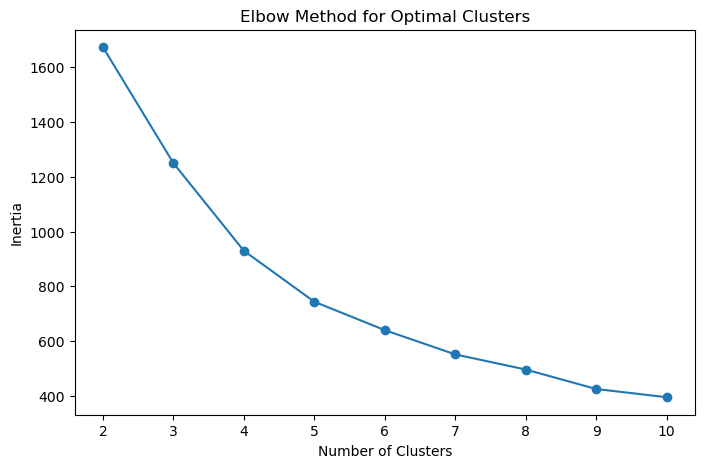

In [147]:
inertia = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(scaled_features).inertia_ for k in cluster_options]
plt.figure(figsize=(8, 5))
plt.plot(cluster_options, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Clusters")
plt.show()

### Visualize the clusters

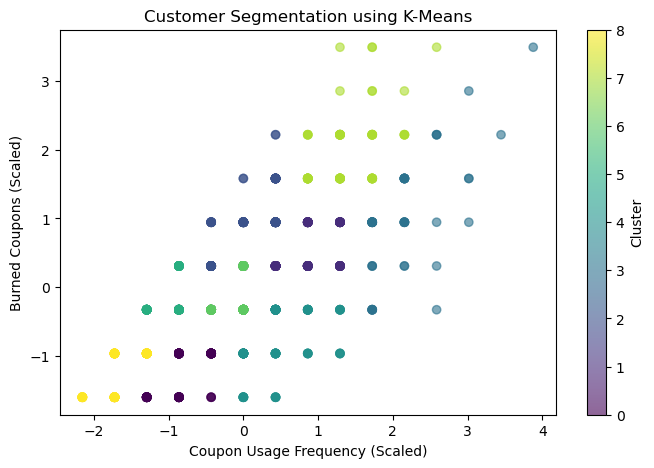

In [148]:

plt.figure(figsize=(8, 5))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=final_df["cluster"], cmap="viridis", alpha=0.6)
plt.xlabel("Coupon Usage Frequency (Scaled)")
plt.ylabel("Burned Coupons (Scaled)")
plt.title("Customer Segmentation using K-Means")
plt.colorbar(label="Cluster")
plt.show()

# cluster analysis

In [149]:
# Analyze the clusters
cluster_analysis = final_df.groupby("cluster")[features].mean()
print(cluster_analysis)

         coupon_usage_frequency    burned  subscribed
cluster                                              
0                      3.142857  0.621849    2.521008
1                      6.992424  3.325758    3.666667
2                      5.000000  3.835616    1.164384
3                     10.000000  4.102041    5.897959
4                      6.076190  1.371429    4.704762
5                      2.662791  2.197674    0.465116
6                      4.652850  2.300518    2.352332
7                      8.211268  5.633803    2.577465
8                      1.363636  0.656566    0.707071
